# Preprocessing - Wine.com

In [1]:
#imports
import numpy as np
import pandas as pd
import os
import re
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry

In [2]:
#set directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
raw_folder = parent_directory + '/data/wine-com/raw/'
processed_folder = parent_directory + '/data/wine-com/processed/'

### Load Data

In [3]:
data = dict()

with open(raw_folder + '1678665697.3855994.txt', newline='\r\n') as file:
    header = next(file)
    data['lines'] = file.readlines()

data['data'] = []

for line in data['lines']:
    values = line.strip().split('|')
    if len(values) == 8:
        row = {
            'Product_Name': values[0],
            'Product_Varietal': values[1],
            'Product_Origin': values[2],
            'Product_Price': values[3],
            'Product_Attributes': values[4],
            'Critical_Reviews': values[5],
            'User_Avg_Rating': values[6],
            'User_Rating_Count': values[7]
        }

        data['data'].append(row)

In [4]:
df = pd.DataFrame(data['data'])

In [5]:
df.head()

,Product_Name,Product_Varietal,Product_Origin,Product_Price,Product_Attributes,Critical_Reviews,User_Avg_Rating,User_Rating_Count
0,Clos Amador Cava Tendre Rose,Sparkling Rosé,"Cava, Spain",12,"Sparkling & Champagne,",92,4.3,64
1,Herdade de Sao Miguel Reserva 2019,Other Red Blends,"Alentejo, Portugal",22,"Red Wine,",94,4.2,5
2,Proyecto Salvaje del Moncayo Garnacha 2020,Grenache,"Navarra, Spain",12,"Red Wine,",92 91,4.6,21
3,La Lecciaia Orvieto Classico 2021,Other White Blends,"Umbria, Italy",12,"White Wine,",90,5.0,23
4,Laurent-Perrier Grand Siecle No. 25,Non-Vintage Sparkling Wine,"Champagne, France",250,"Sparkling & Champagne,Collectible,",99 97 97 96 95 95,4.7,6


### Data Preprocessing

In [6]:
def parse_vintage(text):
    text = text[-4:]
    return re.sub(r'\D', '', text)

df['Product_Vintage'] = df['Product_Name'].apply(parse_vintage)

df['Product_Vintage'] = df['Product_Vintage'].replace('', 0)
df['Product_Vintage'] = df['Product_Vintage'].astype(int)
df = df[df['Product_Vintage'] > 2000]

<AxesSubplot:xlabel='Product_Vintage', ylabel='Count'>

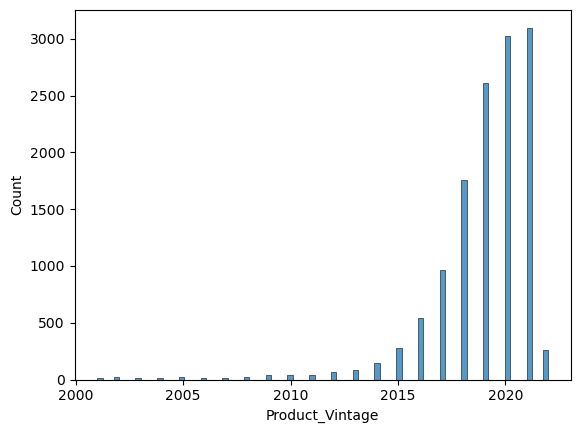

In [7]:
sns.histplot(data = df, x = 'Product_Vintage')

In [8]:
def clean_product_name(text):
    return re.sub(r'\d+', '', text)

df['Product_Name'] = df['Product_Name'].apply(clean_product_name)

In [9]:
def add_price_fractional(text):
    return text + '.99'

df['Product_Price'] = df['Product_Price'].apply(add_price_fractional)

In [10]:
def parse_family(text):
    return text.split(',')[0]

df['Product_Attributes'] = df['Product_Attributes'].apply(parse_family)

In [11]:
def average_critical_scores(text):
    scores_string = re.sub(r'^\s+|\s+$', '', text)
    scores = scores_string.split()
    count_score = len(scores)
    sum_scores = 0
    for score in scores:
        sum_scores += int(score)
    try:
        avg_score = sum_scores/count_score
    except Exception:
        avg_score = None
    return avg_score

df['Critical_Avg_Rating'] = df['Critical_Reviews'].apply(average_critical_scores)

In [12]:
def count_critical_scores(text):
    scores_string = re.sub(r'^\s+|\s+$', '', text)
    scores = scores_string.split()
    count_score = len(scores)
    return count_score

df['Critical_Rating_Count'] = df['Critical_Reviews'].apply(count_critical_scores)
df = df[df['Critical_Rating_Count'] > 2]

<AxesSubplot:xlabel='Critical_Rating_Count', ylabel='Count'>

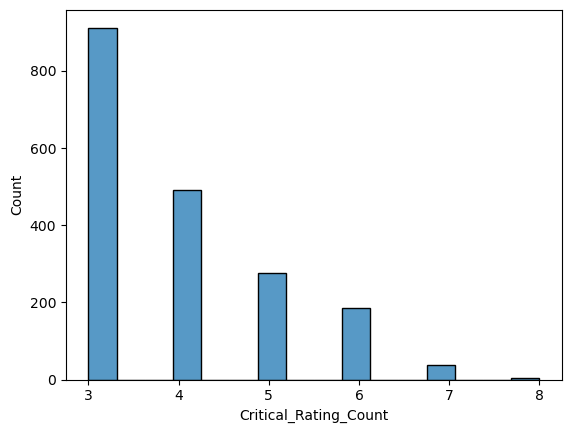

In [13]:
sns.histplot(data = df, x = 'Critical_Rating_Count')

In [14]:
def origin_processing(text):
    #reconciling wine-com naming schemas
    wine_com_state_ids = ['California', 'Washington', 'Oregon']
    wine_com_generic_other_id = 'Other U.S.'

    #split into origin components
    origin_components = text.split(', ')

    if origin_components[-1] in wine_com_state_ids:
        origin_components[-1] = origin_components[-1] + ', United States'
    elif origin_components[-1] == wine_com_generic_other_id:
        origin_components[-1] = 'United States'
    else:
        pass

    #join target list
    origin = ', '.join(origin_components)
    return origin
        
df['Product_Origin'] = df['Product_Origin'].apply(origin_processing)

In [15]:
def product_origin_specificity(text):
    if text is not None:
        appellation_list = text.split(',')
        appellation_level = len(appellation_list)
    else:
        appellation_level = 0
    return appellation_level

df['Product_Origin'] = df['Product_Origin'].replace('', None)
df['Appellation_Level'] = df['Product_Origin'].apply(product_origin_specificity)
df = df[df['Appellation_Level'] >= 2]
df = df.sort_values(by = ['Appellation_Level'], ascending=False)

<AxesSubplot:xlabel='Appellation_Level', ylabel='Count'>

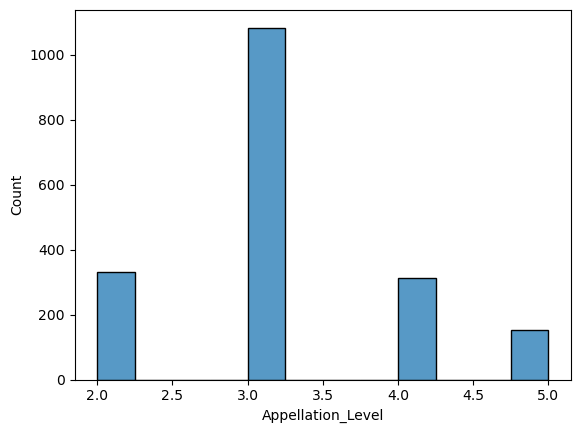

In [16]:
sns.histplot(data = df, x = 'Appellation_Level')

### Data Trimming

In [17]:
df = df.drop(columns = ['Critical_Reviews'])

### Data Review

In [18]:
df.head()

,Product_Name,Product_Varietal,Product_Origin,Product_Price,Product_Attributes,User_Avg_Rating,User_Rating_Count,Product_Vintage,Critical_Avg_Rating,Critical_Rating_Count,Appellation_Level
11627,Domaine Taupenot-Merme Nuits-Saint-Georges Les...,Pinot Noir,"Nuits-St-Georges, Cote de Nuits, Cote d'Or, Bu...",199.99,Red Wine,0.0,0,2017,93.000000,3,5
14016,Domaine de la Romanee-Conti Echezeaux Grand Cru,Pinot Noir,"Flagey-Echezeaux, Cote de Nuits, Cote d'Or, Bu...","3,299.99",Red Wine,0.0,0,2018,95.000000,4,5
12670,Lincourt Rancho Santa Rosa Pinot Noir,Pinot Noir,"Sta. Rita Hills, Santa Barbara, Central Coast,...",40.99,Red Wine,4.0,31,2018,90.666667,3,5
14007,Domaine Claude Dugat Gevrey-Chambertin,Pinot Noir,"Gevrey-Chambertin, Cote de Nuits, Cote d'Or, B...",179.99,Red Wine,0.0,0,2020,92.000000,3,5
7777,Domaine Prieur-Brunet Santenay Maladiere Premi...,Pinot Noir,"Santenay, Cote de Beaune, Cote d'Or, Burgundy,...",65.99,Red Wine,0.0,0,2020,92.333333,3,5


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1878 entries, 11627 to 14258
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Product_Name           1878 non-null   object 
 1   Product_Varietal       1878 non-null   object 
 2   Product_Origin         1878 non-null   object 
 3   Product_Price          1878 non-null   object 
 4   Product_Attributes     1878 non-null   object 
 5   User_Avg_Rating        1878 non-null   object 
 6   User_Rating_Count      1878 non-null   object 
 7   Product_Vintage        1878 non-null   int32  
 8   Critical_Avg_Rating    1878 non-null   float64
 9   Critical_Rating_Count  1878 non-null   int64  
 10  Appellation_Level      1878 non-null   int64  
dtypes: float64(1), int32(1), int64(2), object(7)
memory usage: 233.3+ KB


### Clean & Write Data

In [20]:
df.to_csv(processed_folder + '1678665697.3855994.txt',
          sep = '|',
          index=False)